# Import libraries and data

In [1]:
# import libraries and modules

import pandas as pd 
import numpy as np 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# load movies
movies_meta = pd.read_csv('data/movies_metadata.csv', low_memory=False)

In [3]:
movies_meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

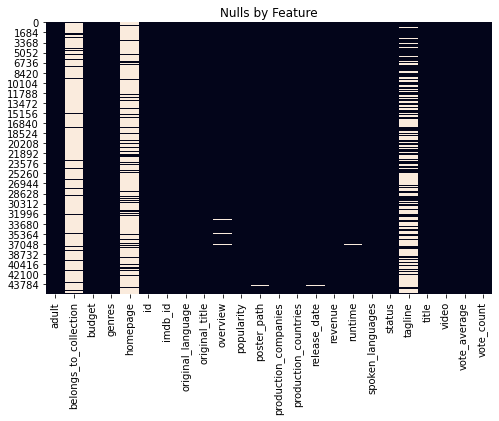

In [5]:
# visualize nulls for each feature

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(movies_meta.isnull(), cbar=False)
ax.set_title('Nulls by Feature')
plt.show()

# Data Cleaning
We will need to do some initial cleaning before we move on to building our recommender system. First, we need to convert a few object columns to numeric to allow for accurate filtering.

In [6]:
int_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

movies_meta[int_cols] = movies_meta[int_cols].apply(pd.to_numeric, errors='coerce')


# Content-based Recommender
This section with build a recommendation based on the movie's plot description by calculating pairwise cosine similarity scores for all movies and assigning a similarity score threshold.

Effectively, we will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors using scikit-learn's TfIdfVectorizer to computer the TF-IDF matrix.

In [7]:
# data of interest in 'overview' column

movies_meta['overview']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
45461          Rising and falling between a man and woman.
45462    An artist struggles to finish his work while a...
45463    When one of her hits goes wrong, a professiona...
45464    In a small town live two brothers, one a minis...
45465    50 years after decriminalisation of homosexual...
Name: overview, Length: 45466, dtype: object

As we saw during EDA, we have NaNs in the 'overview' columns that we need to deal with before building our TF-IDF. Let's replace NaNs with blanks.

In [8]:
# replace NaNs with blanks ("")

movies_meta['overview'] = movies_meta['overview'].fillna('')

That's it--we're ready to build our vectorizer!

In [9]:
# defining vectorizer object and removing English stop words

tfidf = TfidfVectorizer(stop_words='english')

In [10]:
# fit data to create matrix

tfidf_matrix = tfidf.fit_transform(movies_meta['overview'])

In [11]:
tfidf_matrix.shape

print(f""" 
{tfidf_matrix.shape}
Movies Observed: {tfidf_matrix.shape[0]}
Vocabularies/Words Observed: {tfidf_matrix.shape[1]}
""")

 
(45466, 75827)
Movies Observed: 45466
Vocabularies/Words Observed: 75827



Now that we have our matrix, we can begin computing similarities scores.

# Similarity Scores
This section will use cosign similarity to quantify similaries between movies. While scikit-learn does include a *cosign_similarities()* module, we will use *linear_kernel()* instead. We have already created our TF-IDF vectorizer; therefore, calculating the dot product between each vector directly with linear_kernel() will give us the cosign similarity score and should calculate faster than cosign_similarities().

In [12]:
# compute cosign similarity matrix
cos_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [13]:
cos_sim.shape

(45466, 45466)

We now have a 45466 x 45466 matrix that calculates cosine similarity of each movie with every other movie. This means each movie is now a 1 x 45466 vector where each column will be a similarity score for each other movie.

# Recommender System
Now that we have similarity scores and have identified the matrix indinces by `title`, we can start building our recommender system that will:
<ul>
    <li>Get index of movie given a title.</li>
    <li>Get cosine similarity scores for given movie with all other movies, and return a tuple of (position, similarity score). </li>
    <li>Sort tuples based on similarity scores and return titles corresponding to the indices of the Top 10 elements in the list (ignoring the first element, which is the movie itself)</li>
</ul>

In [14]:
# Function to accept a movie title and return titles of 10 similar movies

def get_recommendations(title, cos_sim = cos_sim):

    # get index of movie give a title
    # idx = indices[title]
    idx = movies_meta[movies_meta['title']==title].sort_values(by='popularity', ascending=False)[:1].index.values[0]

    # get similarity scores for given movie
    sim_scores = list(enumerate(cos_sim[idx]))

    # sort based on score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get scores of 10 similar movies, skipping index [0]
    sim_scores = sim_scores[1:11]

    # get movie indices
    movie_indices = [i[0] for i in sim_scores]

    # return top 10 most similar movies
    return movies_meta['title'].iloc[movie_indices]

Nice. Now it's time to try it out to see how well it works.

In [15]:
get_recommendations('The Dark Knight')

18252                                The Dark Knight Rises
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
21194    Batman Unmasked: The Psychology of the Dark Kn...
150                                         Batman Forever
20232              Batman: The Dark Knight Returns, Part 2
40974    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
41982    Batman Beyond Darwyn Cooke's Batman 75th Anniv...
19792              Batman: The Dark Knight Returns, Part 1
18035                                     Batman: Year One
Name: title, dtype: object